#AI-Driven Learning Difficulty Detection System

## **Business Context**

In modern education, identifying students who are struggling before they fall behind is crucial. Traditionally, teachers rely on intuition and manual assessments, but AI can detect patterns earlier by analyzing student performance over time.

This project builds an AI-powered learning analytics system that:

1.  Detects students at risk of learning difficulties early
2.  Recommends personalized interventions to help them improve
3.  Predicts future performance trends using time-series models

By combining rule-based detection, machine learning (ML), and deep learning (LSTM), this system enables schools, tutors, and online learning platforms to proactively support struggling students.

## **Data Description**

Using a sample student score dataset to train the model to achieve the project goals.

The dataset used consists of student learning records collected over time. Each row represents a student's activity session and contains:

*   student_id : Unique identifier for the student
*   date: Date of activity
*   activity: Type of learning task
*   score: Performance score (0-100)
*   time_spent_minutes: Minutes spent on task
*   used_hints:	Whether hints were used
*   late_submission: Whether the submission was late

## **Project Goals**

This project aims to automate the early detection of learning difficulties using a multi-layered AI approach:


**1.   Rule-Based Detection**

Flags risk factors (e.g., multiple low scores, repeated hint use)

**2.   Machine Learning Classifier (Risk Prediction)**

A. Build a Random Forest model to predict whether a student is at risk (0 or 1)

B. Outputs confidence scores on how much percentage a student is struggling.

**3.   LSTM Time-Series Model (Future Score Prediction)**

Predicts the student's next quiz score based on past performance and help teachers monitor the trend.

# **1. Rule-Based Detection**

In [10]:
# Define detect_learning_issues function
def detect_learning_issues(student_data):
    """
    This function contain logic for detecting learning issues based on student data.
    """

    flags = []
    for record in student_data:

        # Struggling with content
        if record['score'] < 60 and record['time_spent'] > 45 and record['used_hint'] and record['late_submission']:
            flags.append("Struggling with content")

        # Low engagement
        if record['time_spent'] < 15 and not record['used_hint']:
            flags.append("Low engagement")

        # Repeated low scores
        if record['score'] < 50:
            flags.append("Consistently low scores")

        # Late submissions
        if record['late_submission']:
            flags.append("Frequent late submissions")

        # Heavy hint dependency
        if record['used_hint'] and record['time_spent'] > 30:
            flags.append("Hint-dependent learning")

        # Inconsistent performance
        if abs(record['score'] - record.get('last_score', record['score'])) > 30:
            flags.append("Inconsistent performance")

    return list(set(flags))

In [11]:
# Define get_interventions function
def get_interventions(flags):
    """
    This function provide recommendations based on detected flags.
    """

    interventions = []

    if "Struggling with content" in flags:
      interventions.append("Recommend individualized tutoring or remedial sessions")

    if "Low engagement" in flags:
        interventions.append("Encourage gamified learning or interactive sessions")

    if "Consistently low scores" in flags:
        interventions.append("Schedule a parent-teacher meeting to assess root causes")

    if "Frequent late submissions" in flags:
        interventions.append("Introduce time management workshops or learning schedules")

    if "Hint-dependent learning" in flags:
        interventions.append("Encourage independent problem solving with guided practice")

    if "Inconsistent performance" in flags:
        interventions.append("Monitor student with regular check-ins to stabilize learning patterns")

    return interventions

### Test the Rule Based system model

In [12]:
# Define the 'sample' data
sample = {
    'score': 58,
    'time_spent': 50,
    'used_hint': True,
    'late_submission': True
}

In [13]:
# Rules-based flags
flags = detect_learning_issues([sample])
interventions = get_interventions(flags)

In [14]:
print(f"Detected Issues:",flags)
print(f"Recommended Interventions:",interventions)

Detected Issues: ['Frequent late submissions', 'Struggling with content', 'Hint-dependent learning']
Recommended Interventions: ['Recommend individualized tutoring or remedial sessions', 'Introduce time management workshops or learning schedules', 'Encourage independent problem solving with guided practice']


# **2. Machine Learning Classifier (Random Forest Model)**

## Importing necessary libraries



In [15]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

import os # Import the os module here
import joblib

# To help with model building
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading the dataset**

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
learn = pd.read_csv("/content/drive/My Drive/Colab Notebooks/mock_student_data.csv")

In [18]:
# copying data to another varaible to avoid any changes to original data
df = learn.copy()

## **Data Overview**

### **Understand Shape of the dataset**

In [19]:
df.shape

(1000, 7)

### **View the first and last 5 rows of the dataset**

In [20]:
df.head()

,student_id,date,activity,score,time_spent,used_hint,late_submission
0,S001,2025-03-23,Science Exercise,49,20,False,False
1,S001,2025-03-16,Science Exercise,50,44,False,True
2,S001,2025-03-26,Reading,42,44,False,False
3,S001,2025-03-13,Science Exercise,50,43,False,True
4,S001,2025-03-04,Reading,62,23,True,False


In [21]:
df.tail()

,student_id,date,activity,score,time_spent,used_hint,late_submission
995,S100,2025-03-03,Science Exercise,79,43,True,True
996,S100,2025-03-10,Science Exercise,67,33,True,False
997,S100,2025-03-25,Reading,82,31,False,False
998,S100,2025-03-11,Math Quiz,67,58,False,False
999,S100,2025-03-20,Science Exercise,66,17,False,False


### **View the datatypes details**

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   student_id       1000 non-null   object
 1   date             1000 non-null   object
 2   activity         1000 non-null   object
 3   score            1000 non-null   int64 
 4   time_spent       1000 non-null   int64 
 5   used_hint        1000 non-null   bool  
 6   late_submission  1000 non-null   bool  
dtypes: bool(2), int64(2), object(3)
memory usage: 41.1+ KB


*   There are total 6 columns. Out of which there are 3 object type columns, 2 integer type columns and 2 boolean type columns.
*   All of the columns have 1000 non-null values which indicates there are no missing values.
*   student_id is an integer column, but we cannot perform statistic operations on this column as it is an unique identifier.

### **Check for duplicate values**

In [23]:
df.duplicated().sum()

np.int64(0)

*   There are no duplicated entries.

### **Statistical Summary**

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
score,1000.0,66.370,12.569212,36.0,57.0,67.0,76.0,94.0
time_spent,1000.0,37.497,13.303194,15.0,26.0,37.0,49.0,60.0


In [25]:
df.describe(include=["object"]).T

,count,unique,top,freq
student_id,1000,100,S001,10
date,1000,30,2025-03-20,49
activity,1000,3,Reading,346


In [26]:
#get unique values from activity column
df["activity"].unique()

array(['Science Exercise', 'Reading', 'Math Quiz'], dtype=object)

In [27]:
#find the range of period from date column
df["date"].min(), df["date"].max()

('2025-03-01', '2025-03-30')

## **Exploratory Data Analysis (EDA)**

### **Univariate Analysis**

#### Score Distribution

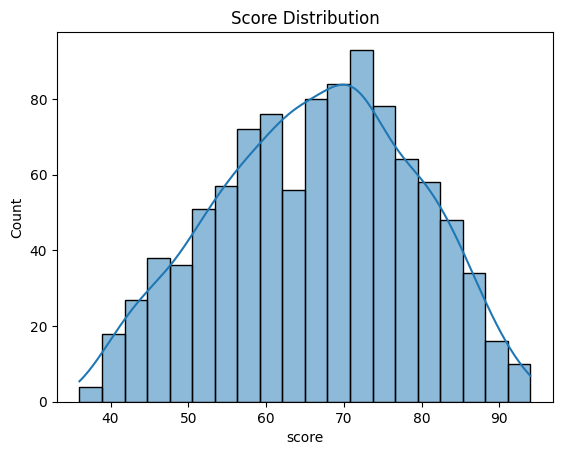

In [28]:
sns.histplot(df['score'], bins=20, kde=True)
plt.title("Score Distribution")
plt.show()

Observations:

*   Most students scored in the mid to high range.
*   The score distribution is normal, and not significantly skewed.

*   The distribution is centered around the 60-80 score range.
*   Scores below 50 have relatively fewer students, indicating low scores are less common.





#### Time Spent Distribution

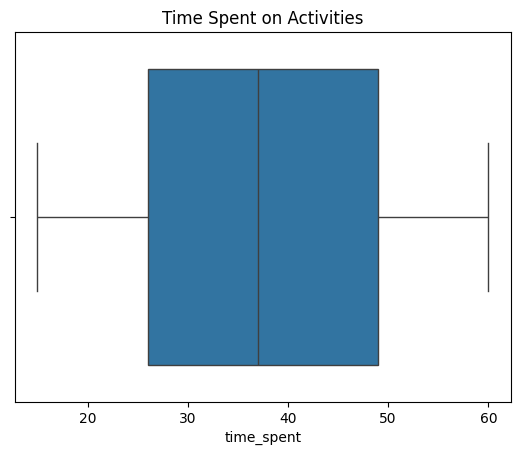

In [29]:
sns.boxplot(x=df['time_spent'])
plt.title("Time Spent on Activities")
plt.show()

### **Bivariate Analysis**

#### Score vs. Time Spent

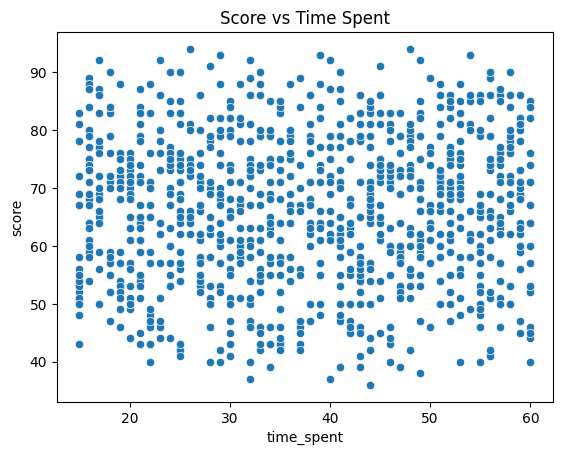

In [30]:
sns.scatterplot(x=df['time_spent'], y=df['score'])
plt.title("Score vs Time Spent")
plt.show()

 #### Score vs. Used Hints

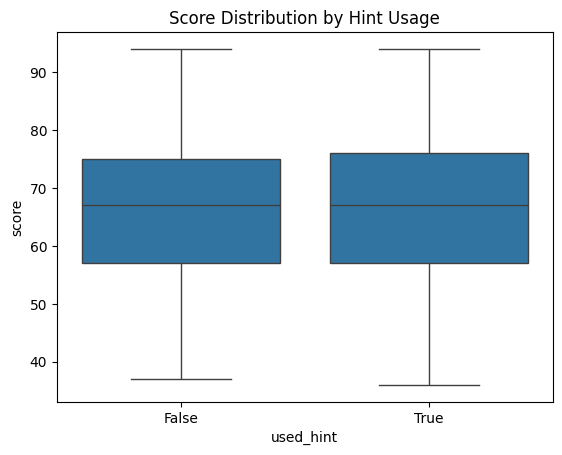

In [31]:
sns.boxplot(x=df['used_hint'], y=df['score'])
plt.title("Score Distribution by Hint Usage")
plt.show()

Observation:

*   Using hints does not strongly correlate with worse performance.
Performance appears comparable between students who used hints and those who didn’t.


### **Correlation Matrix**

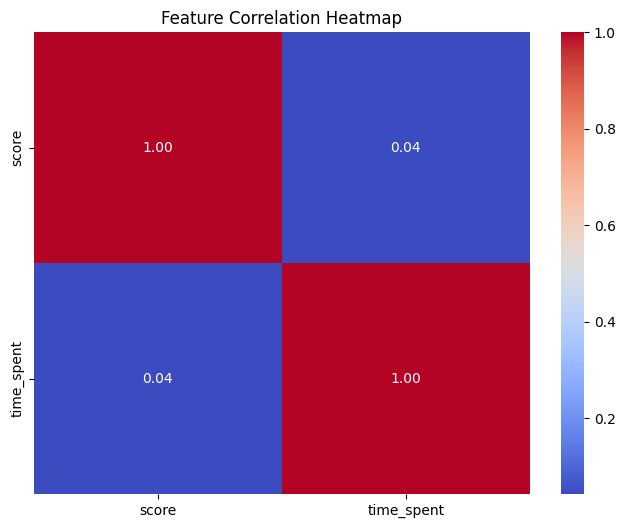

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt=".2f") # only numeric columns for correlation
plt.title("Feature Correlation Heatmap")
plt.show()

Observations

*   No strong relationships exist between score and time spent.


#### Trends Over Time (Time-Series Analysis)

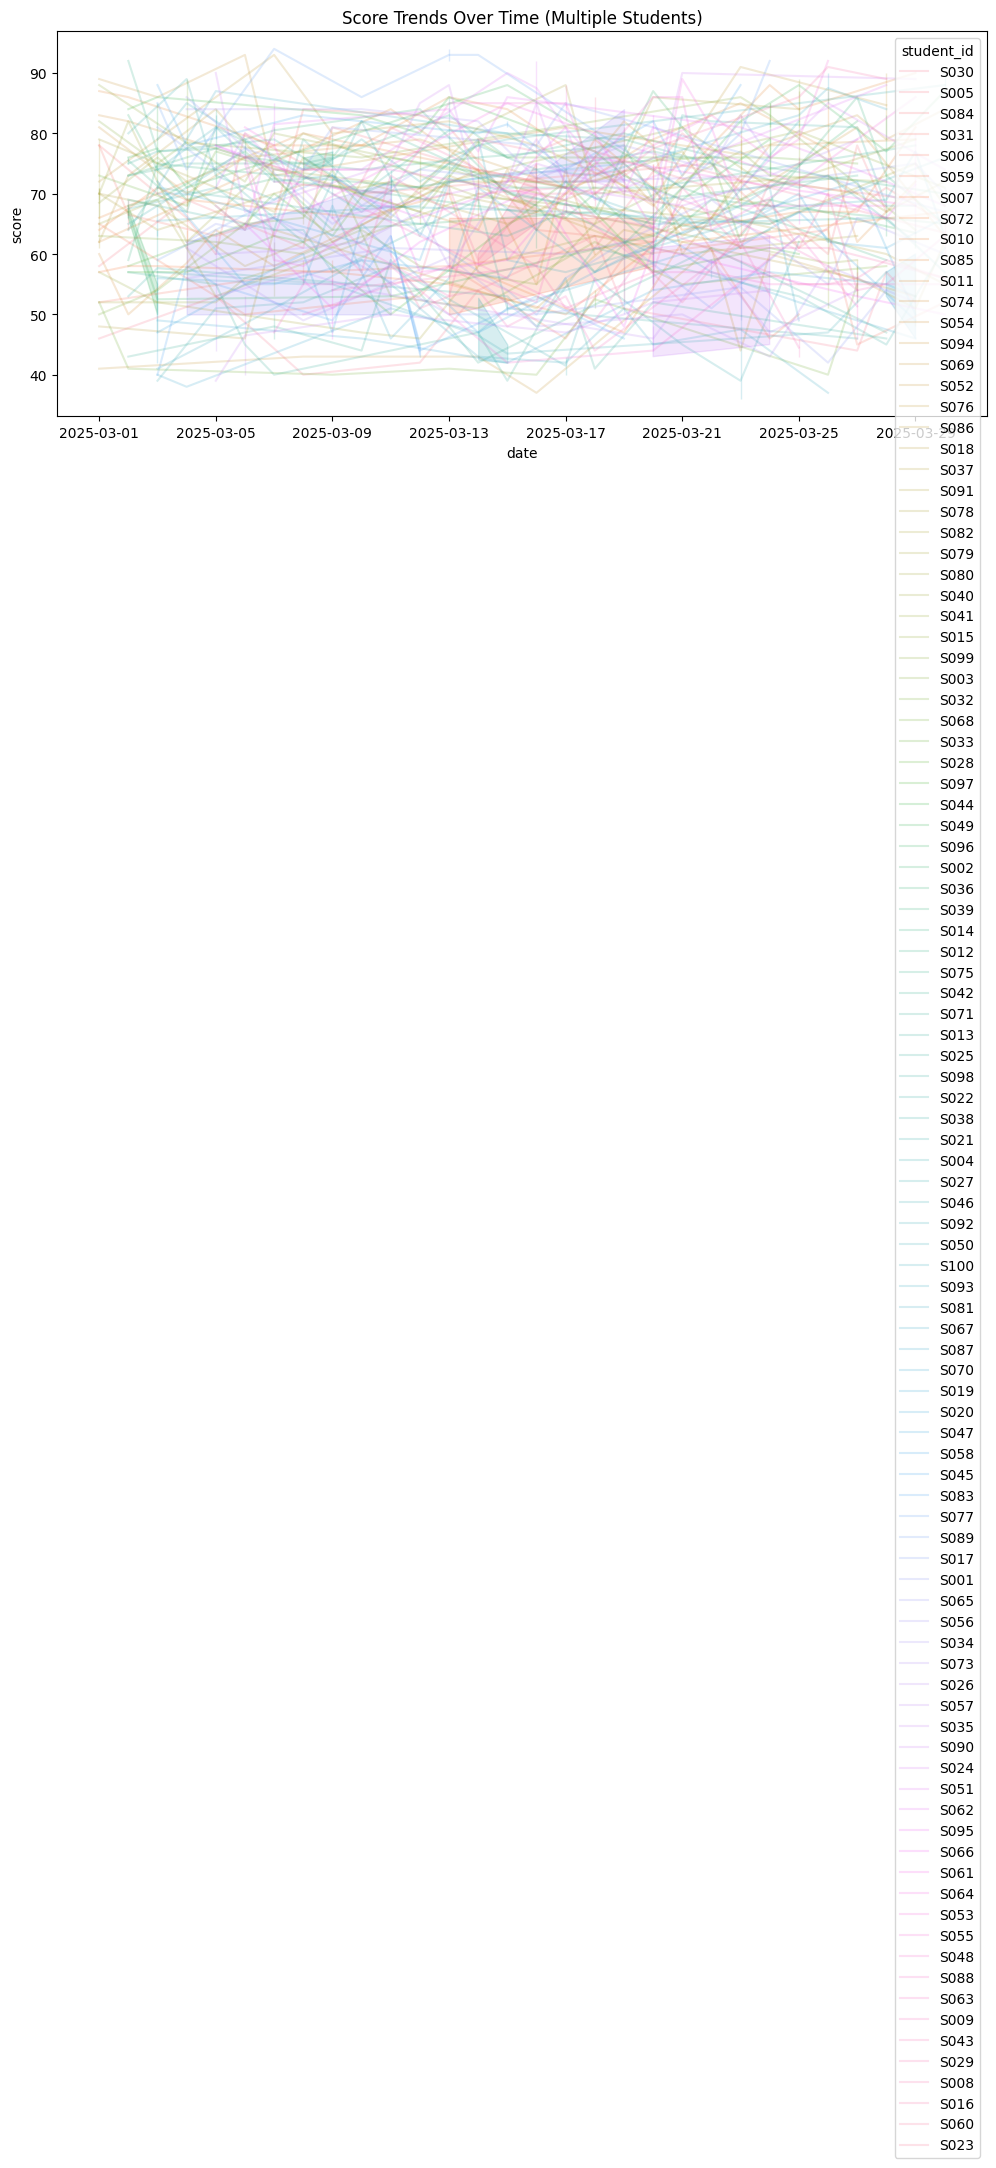

In [33]:
#Check learning progress over time
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="date", y="score", hue="student_id", alpha=0.2)
plt.title("Score Trends Over Time (Multiple Students)")
plt.show()

#### Time-Series Analysis (for sample 5 students)

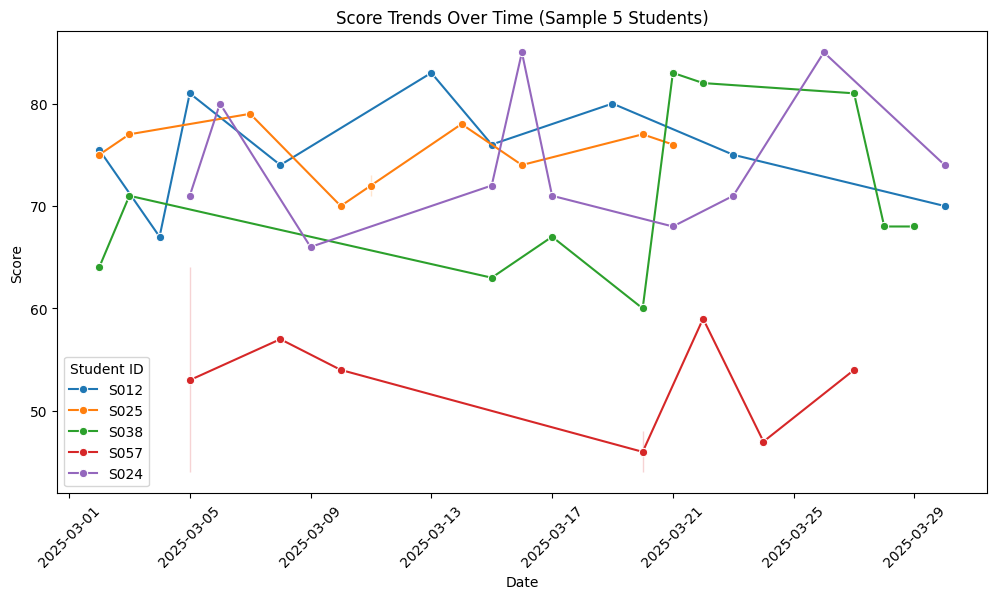

In [34]:
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Randomly select 5 students
sample_students = df['student_id'].sample(6, random_state=42).unique()
df_sample = df[df['student_id'].isin(sample_students)]

# Plot score trends for selected students
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sample, x="date", y="score", hue="student_id", marker="o")
plt.title("Score Trends Over Time (Sample 5 Students)")
plt.xlabel("Date")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Student ID")
plt.show()

#### Overall trend across the class

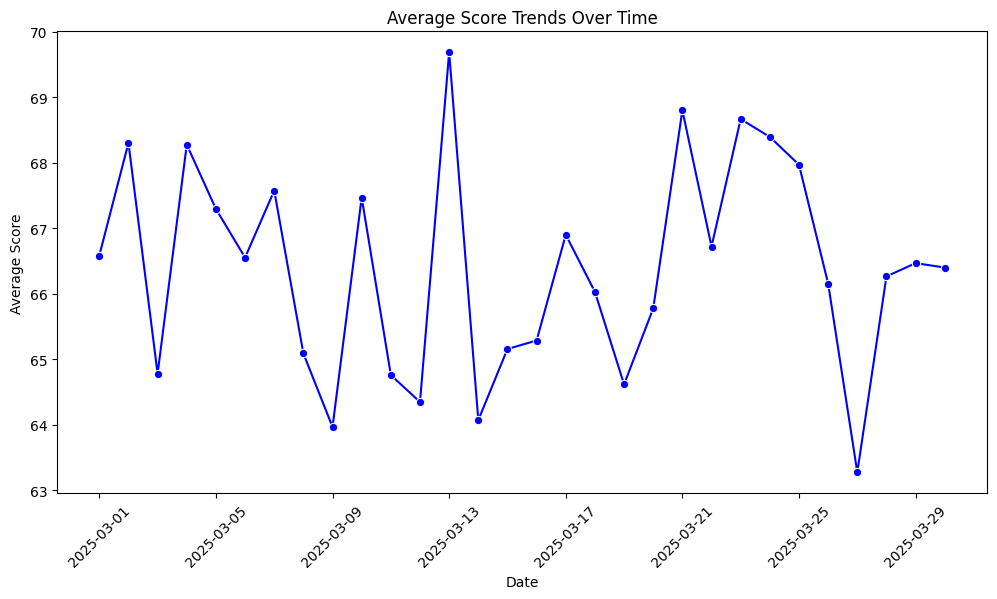

In [35]:
#Aggregate Scores for All Students
df_avg = df.groupby("date")["score"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg, x="date", y="score", marker="o", color="blue")
plt.title("Average Score Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.show()

**Observations:**

*   Plot shows overall trends rather than individual student noise which is Useful for detecting patterns across the entire class.

*   But there is no consistent trend. There is high variability with frequent ups and downs.

*   Lowest dip on March 26; highest peak around March 12.

*   The kind of fluctuation suggests inconsistency in either performance or assessment.

#### Interactive Plot with Hover (Plotly)

In [36]:
import plotly.express as px

# Filter for 5 sample students
df_sample = df[df['student_id'].isin(sample_students)]

fig = px.line(df_sample, x="date", y="score", color="student_id", markers=True,
              title="Interactive Score Trends Over Time (5 Sample Students)")
fig.update_xaxes(title="Date", tickangle=-45)
fig.update_yaxes(title="Score")
fig.show()

## Model evaluation criterion

##### **Classification Model (Risk Prediction)**

For the classification model, we will use the following metrics.

1. **Accuracy** - Measures overall correctness of predictions.
2. **Precision** (Positive Predictive Value) - Measures how many predicted struggling students are actually struggling. It is important to minimize the false positives (misclassifying normal students as struggling).
3. **Recall** (Sensitivity) - Measures how many actual struggling students were correctly identified. It is important to there should be no false negatives (failing to identify struggling students).
4. **F1-Score**(Balanced Metric) - Harmonic mean of precision & recall.
5. **Confusion Matrix** - Provides a breakdown of true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN). Helps analyze where the model is making mistakes.

##### **Time-Series Model (Score Prediction)**

For predicting future scores, we will evaluate the LSTM model using regression-based metrics.

 **Mean Absolute Error (MAE)** - Measures the average absolute difference between actual and predicted scores. Easier to interpret as it gives errors in actual score units.

## Classification Model Building

#### Utility Functions

In [37]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

In [38]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

#### **Feature Encoding**

In [39]:
# Simulate 'label': 1 = struggling student, 0 = normal
def label_row(row):
    if row['score'] < 60 and row['time_spent'] > 45 and row['used_hint'] and row['late_submission']:
        return 1
    return 0

df['label'] = df.apply(label_row, axis=1)

In [40]:
#Get the number of rows where label =1
num_rows_with_label_1 = (df['label'] == 1).sum()

#Get the number of rows where label =0
num_rows_with_label_0 = (df['label'] == 0).sum()

In [41]:
num_rows_with_label_1 #number of rows where label =1

np.int64(27)

In [42]:
num_rows_with_label_0 #number of rows where label =0

np.int64(973)

In [43]:
#Display the rows where label =1 (struggling students)
df[df['label'] == 1]

,student_id,date,activity,score,time_spent,used_hint,late_submission,label
47,S005,2025-03-01,Science Exercise,58,49,True,True,1
914,S092,2025-03-03,Reading,57,47,True,True,1
812,S082,2025-03-03,Science Exercise,52,56,True,True,1
734,S074,2025-03-04,Reading,53,58,True,True,1
578,S058,2025-03-06,Science Exercise,55,48,True,True,1
733,S074,2025-03-07,Science Exercise,58,47,True,True,1
428,S043,2025-03-09,Math Quiz,54,57,True,True,1
347,S035,2025-03-11,Math Quiz,50,57,True,True,1
985,S099,2025-03-12,Science Exercise,58,51,True,True,1
256,S026,2025-03-13,Science Exercise,58,49,True,True,1


In [44]:
#Display the rows where label =0 (Normal Students)
df[df['label'] == 0]

,student_id,date,activity,score,time_spent,used_hint,late_submission,label
292,S030,2025-03-01,Reading,46,43,False,True,0
832,S084,2025-03-01,Science Exercise,78,15,False,True,0
308,S031,2025-03-01,Math Quiz,78,42,False,False,0
59,S006,2025-03-01,Math Quiz,52,15,True,False,0
585,S059,2025-03-01,Math Quiz,65,17,False,True,0
...,...,...,...,...,...,...,...,...
629,S063,2025-03-30,Reading,62,57,False,True,0
556,S056,2025-03-30,Science Exercise,60,31,False,False,0
236,S024,2025-03-30,Science Exercise,74,32,True,False,0
55,S006,2025-03-30,Science Exercise,52,18,True,True,0


**Observations:**

*   The dataset clearly shows it is **not balanced dataset**.
*   Not Struggling students are more than the struggling students in this dataset.


In [45]:
# Feature encoding (Identify the Independent and dependent variables)
df['used_hint'] = df['used_hint'].astype(int)
df['late_submission'] = df['late_submission'].astype(int)

features = ['score', 'time_spent', 'used_hint', 'late_submission']
X = df[features]
y = df['label']

#### **Train Test Split**

In [46]:
# Splitting data into training and validation set:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y) ## code to split the data into train test in the ratio 80:20

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp) ## code to split the data into train test in the ratio 75:25

print(X_train.shape, X_val.shape, X_test.shape)

(800, 4) (50, 4) (150, 4)


In [47]:
#Check the ratio of labels in the target column for each of the data segments
print("Training: \n", y_train.value_counts(normalize=True))
print("\n\nValidation: \n", y_val.value_counts(normalize=True))
print("\n\nTest: \n", y_test.value_counts(normalize=True))

Training: 
 label
0    0.9725
1    0.0275
Name: proportion, dtype: float64


Validation: 
 label
0    0.98
1    0.02
Name: proportion, dtype: float64


Test: 
 label
0    0.973333
1    0.026667
Name: proportion, dtype: float64


Train, Validation and Test data set proportion is similar.

#### **Model building**

In [48]:
model_RFC = RandomForestClassifier(n_estimators=100, random_state=42)
model_RFC.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [49]:
# Evaluation on training data
y_pred = model_RFC.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       778
           1       1.00      1.00      1.00        22

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [50]:
# Evaluation on validation data
y_pred = model_RFC.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00         1

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



Observations:

*   Class 0 has 49 samples, but class 1 only has 1
*   Though the model shows perfect score, the model didn't have enough data to predict the class 1. It might be overfitting due to class imbalance.
*   Lets try to evaluate on a more balanced or use balancing techniques like SMOTE(Synthetic Minority Over-sampling Technique).




#### **Model Building with Oversampled data**

In [51]:
print("Before Oversampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label '0': {} \n".format(sum(y_train == 0)))
# Synthetic Minority Over Sampling Technique
sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=42
)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label '1': 22
Before Oversampling, counts of label '0': 778 

After Oversampling, counts of label '1': 778
After Oversampling, counts of label '0': 778 

After Oversampling, the shape of train_X: (1556, 4)
After Oversampling, the shape of train_y: (1556,) 



In [52]:
model_RFC_Over = RandomForestClassifier(n_estimators=100, random_state=42)
model_RFC_Over.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=42)

In [53]:
# Evaluation on train data
y_pred = model_RFC_Over.predict(X_train_over)
print(classification_report(y_train_over, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       778
           1       1.00      1.00      1.00       778

    accuracy                           1.00      1556
   macro avg       1.00      1.00      1.00      1556
weighted avg       1.00      1.00      1.00      1556



In [54]:
# Evaluation on test data
y_pred = model_RFC_Over.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       146
           1       1.00      1.00      1.00         4

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



#### Hyperparameter Tuning

In [55]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train_over, y_train_over)

# Best parameters
print("Best parameters found:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': 'balanced_subsample', 'bootstrap': False}


In [56]:
# Use best parameters
rf1_tuned = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=50,
    class_weight='balanced_subsample',
    bootstrap=False,
    random_state=42
)

# Train the model
rf1_tuned.fit(X_train_over, y_train_over)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=50, min_samples_leaf=4, n_estimators=300,
                       random_state=42)

In [57]:
# Checking model's performance on training set
rf1_train = model_performance_classification_sklearn(rf1_tuned, X_train_over, y_train_over)
rf1_train

,Accuracy,Recall,Precision,F1
0,0.999357,0.998715,1.0,0.999357


In [58]:
# Checking model's performance on validation set
rf1_val = model_performance_classification_sklearn(rf1_tuned, X_val, y_val)
rf1_val

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


#### **Model Building with Undersampled data**

In [59]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [60]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 22
Before Under Sampling, counts of label 'No': 778 

After Under Sampling, counts of label 'Yes': 22
After Under Sampling, counts of label 'No': 22 

After Under Sampling, the shape of train_X: (44, 4)
After Under Sampling, the shape of train_y: (44,) 



In [61]:
model_RFC_un = RandomForestClassifier(n_estimators=100, random_state=42)
model_RFC_un.fit(X_train_un, y_train_un)

RandomForestClassifier(random_state=42)

In [62]:
# Evaluation on validation data
y_pred = model_RFC_un.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        49
           1       0.20      1.00      0.33         1

    accuracy                           0.92        50
   macro avg       0.60      0.96      0.65        50
weighted avg       0.98      0.92      0.94        50



In [63]:
# Evaluation on test data
y_pred = model_RFC_un.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       146
           1       0.36      1.00      0.53         4

    accuracy                           0.95       150
   macro avg       0.68      0.98      0.75       150
weighted avg       0.98      0.95      0.96       150



#### **HyperParameter tuning for undersampled data**

In [64]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='f1',  # or 'roc_auc' for binary classification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train_un, y_train_un)

# Best parameters
print("Best parameters found:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced_subsample', 'bootstrap': True}


In [65]:
# Use best parameters
rf2_tuned = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=10,
    class_weight='balanced_subsample',
    bootstrap=True,
    random_state=42
)

# Train the model
rf2_tuned.fit(X_train_un, y_train_un)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [66]:
# Checking model's performance on training set
rf2_train = model_performance_classification_sklearn(rf2_tuned, X_train_un, y_train_un)
rf2_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [67]:
# Checking model's performance on validation set
rf2_val = model_performance_classification_sklearn(rf2_tuned, X_val, y_val)
rf2_val

,Accuracy,Recall,Precision,F1
0,0.94,1.0,0.25,0.4


#### **Test models**

In [68]:
# Let's check the performance on test set (Random Forest hypertuned with Undersampled data)
rf_test = model_performance_classification_sklearn(rf2_tuned, X_test, y_test)
rf_test

,Accuracy,Recall,Precision,F1
0,0.953333,1.0,0.363636,0.533333


In [69]:
# Let's check the performance on test set (Random Forest hypertuned with Oversampled data)
rf_test1 = model_performance_classification_sklearn(rf1_tuned, X_test, y_test)
rf_test1

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [70]:
# Let's check the performance on test set (Basic model Random Forest)
rf_test3 = model_performance_classification_sklearn(model_RFC, X_test, y_test)
rf_test3

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [71]:
# Let's check the performance on test set (Random Forest trained with Oversampled data)
rf_test4 = model_performance_classification_sklearn(model_RFC_Over, X_test, y_test)
rf_test4

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [72]:
# Let's check the performance on test set (Random Forest trained with Undersampled data)
rf_test5 = model_performance_classification_sklearn(model_RFC_un, X_test, y_test)
rf_test5

,Accuracy,Recall,Precision,F1
0,0.953333,1.0,0.363636,0.533333


🔍 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       973
           1       1.00      1.00      1.00        27

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



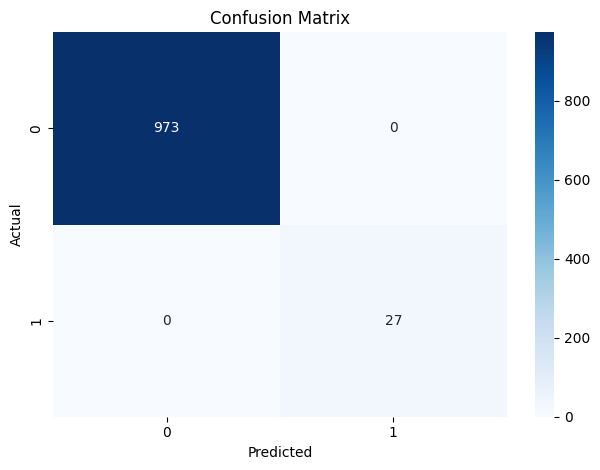

In [73]:
    X = df[features]
    y_true = df['label']

    y_pred = model_RFC.predict(X)

    print("🔍 Classification Report:\n")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

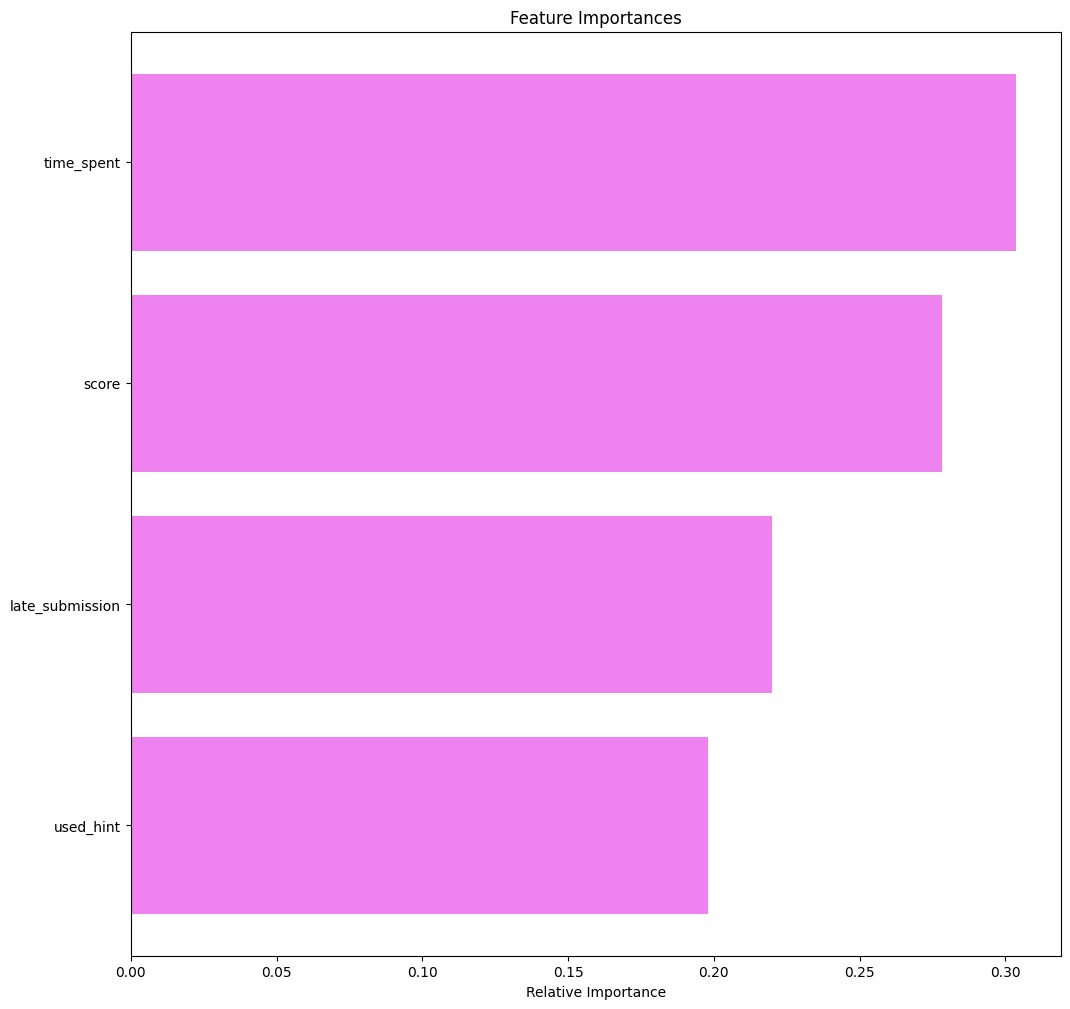

In [74]:
feature_names = X_train.columns
importances = model_RFC.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

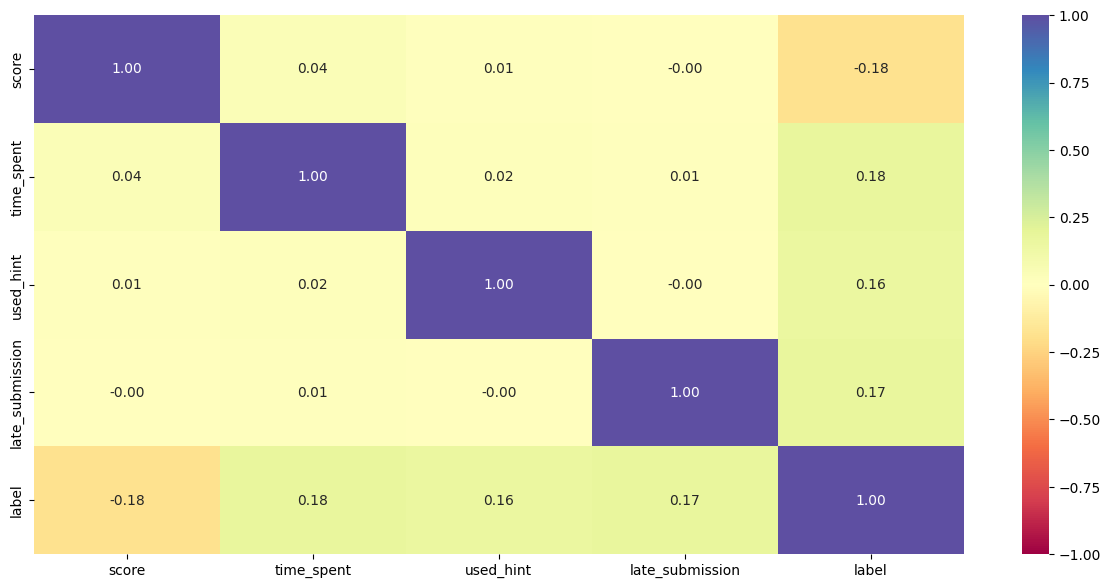

In [75]:
important_features_with_target = ['score', 'time_spent', 'used_hint', 'late_submission', 'label']
plt.figure(figsize=(15, 7))
sns.heatmap(df[important_features_with_target].corr(numeric_only = True), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

#### **Predict the student classificaton with final model**

In [76]:
def predict_student_classification(record):
    df = pd.DataFrame([record])
    df['used_hint'] = df['used_hint'].astype(int)
    df['late_submission'] = df['late_submission'].astype(int)
    features = ['score', 'time_spent', 'used_hint', 'late_submission']
    # Predict class
    predicted_class = model_RFC.predict(df[features])
    #print("Predicted Class:", predicted_class[0])  # 0 = Normal, 1 = At Risk
    return predicted_class[0]

In [77]:
# Define the 'sample' data before calling the function
sample = {
    'score': 58,
    'time_spent': 50,
    'used_hint': True,
    'late_submission': True
}

In [78]:
predclass = predict_student_classification(sample)
print("Predicted Class:", predclass)  # 0 = Normal, 1 = At Risk
print(f"Student {'At Risk' if predclass else 'OK'}")

Predicted Class: 1
Student At Risk


In [79]:
# Define the 'sample' data before calling the function
sample1 = {
    'score': 98,
    'time_spent': 50,
    'used_hint': False,
    'late_submission': False
}

In [80]:
predclass = predict_student_classification(sample1)
print("Predicted Class:", predclass)  # 0 = Normal, 1 = At Risk
print(f"Student {'At Risk' if predclass else 'OK'}")

Predicted Class: 0
Student OK


## B. Add Confidence Scores to Random Forest Classifier

In [81]:
def predict_difficulty_with_confidence(record):
    df = pd.DataFrame([record])
    df['used_hint'] = df['used_hint'].astype(int)
    df['late_submission'] = df['late_submission'].astype(int)
    features = ['score', 'time_spent', 'used_hint', 'late_submission']
    prob = model_RFC.predict_proba(df[features])[0][1]  # Probability of label = 1 (struggling)
    prediction = int(prob > 0.5)
    return prediction, round(prob * 100, 2)

In [82]:
# Define the 'sample' data before calling the function
sample = {
    'score': 58,
    'time_spent': 50,
    'used_hint': True,
    'late_submission': True
}

In [83]:
pred, conf = predict_difficulty_with_confidence(sample)
print(f"{'At Risk' if pred else 'OK'} (Confidence: {conf}%)")

At Risk (Confidence: 96.0%)


# 3. Time-Series Modeling with LSTM (for individual student trends)

Predict future performance (e.g., next quiz score) or future risk level based on a sequence of prior sessions.

###  Prepare Sequential Data

Each student will have a time-ordered sequence of activities with features like: score, time_spent, used_hint, late_submission

In [86]:
def load_student_sequences(csv_path, seq_len=5):
    #Reads the CSV file at csv_path into a pandas DataFrame called df
    df = pd.read_csv(csv_path)
    #Converts the used_hint and late_submission columns to integers
    df['used_hint'] = df['used_hint'].astype(int)
    df['late_submission'] = df['late_submission'].astype(int)
    #Sorts the DataFrame first by student_id and then by date, ensuring that each student’s activities are in chronological order.
    df.sort_values(['student_id', 'date'], inplace=True)

    X, y = [], []
    #Loops through the DataFrame grouped by student_id, to processes each student's data separately.
    for student_id, group in df.groupby('student_id'):
        group = group.reset_index(drop=True) #group is the subset of data for one student. Resets the index of each student’s group to start from 0. This helps to avoid issues with the original index when slicing rows.
        for i in range(len(group) - seq_len):
            seq = group.loc[i:i+seq_len-1, ['score', 'time_spent', 'used_hint', 'late_submission']].values
            label = group.loc[i+seq_len, 'score']  # Next score as target
            X.append(seq)
            y.append(label)

    return np.array(X), np.array(y)

### Build and Train LSTM Model

In [87]:
# Load sequences and define the Dependent (Y) and Independednt (X) variables
X, y = load_student_sequences('/content/drive/MyDrive/Colab Notebooks/mock_student_data.csv')

# Normalize target scores
y = y / 100.0

In [88]:
# Split the sequential data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1)

In [89]:
# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(1, activation='sigmoid')  # Predict normalized score
])

In [90]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
model.fit(X, y, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0409 - mae: 0.1678 - val_loss: 0.0153 - val_mae: 0.1007
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - mae: 0.0996 - val_loss: 0.0088 - val_mae: 0.0765
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - mae: 0.0859 - val_loss: 0.0077 - val_mae: 0.0723
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - mae: 0.0768 - val_loss: 0.0074 - val_mae: 0.0706
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - mae: 0.0739 - val_loss: 0.0074 - val_mae: 0.0716
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - mae: 0.0736 - val_loss: 0.0070 - val_mae: 0.0698
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0685 - val_loss: 0.0072 - val_mae: 0.0702
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mae: 0.0705 - val_loss: 0.0073 - val_mae: 0.0703
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - mae:

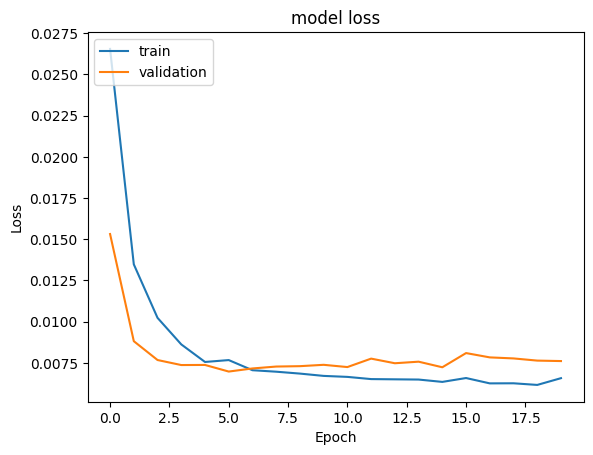

In [91]:
#Plotting Train Loss vs Validation Loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

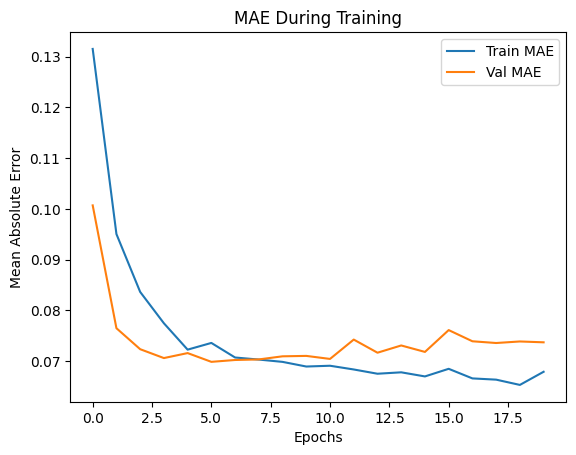

In [92]:
# If you have history object from model.fit()
plt.plot(model.history.history['mae'], label='Train MAE')
plt.plot(model.history.history['val_mae'], label='Val MAE')
plt.title('MAE During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

### Predict Future Score

In [93]:
def predict_next_score(student_df):
    #student_df - DataFrame containing a single student's historical data.

    #Sorts the student data by date to ensure chronological order, which is crucial for sequence prediction.
    student_df = student_df.sort_values('date')

    #Converts the used_hint and late_submission columns to integers
    student_df['used_hint'] = student_df['used_hint'].astype(int)
    student_df['late_submission'] = student_df['late_submission'].astype(int)

    #Defines the list of features that the model expects for prediction.
    features = ['score', 'time_spent', 'used_hint', 'late_submission']
    #Extracts the last 5 rows of the specified features which gets the most recent 5 records
    last_seq = student_df[features].tail(5).values

    #If there are fewer than 5 records, it returns None because there's not enough data to form a full sequence.
    if last_seq.shape[0] < 5:
        return None  # Not enough data

    #Reshapes the sequence into the format the LSTM model expects: 1: this prediction is for one student, 5: five time steps, 4: four features per time step (score, time_spent, used_hint, late_submission)
    #LSTMs require 3D input
    last_seq = last_seq.reshape((1, 5, 4))

    #Runs the model to predict the next score based on the input sequence.
    predicted = model.predict(last_seq)[0][0]
    #Assumes the model predicted a score normalized between 0 and 1, so it scales it back to 0–100. And Rounds the final score to 2 decimal places
    return round(predicted * 100, 2)

In [94]:
# Select some sample student to predict
student_df = df[df['student_id'] == 'S005'].sort_values("date")

In [95]:
# LSTM future score prediction
predicted_score = predict_next_score(student_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


In [96]:
print(f"Predicted next score for student S005: {predicted_score}")

Predicted next score for student S005: 64.9000015258789


### Evaluate the model

In [97]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0) # verbose=0 will suppress the output
print(f"Test MAE: {mae}")

Test MAE: 0.0604964904487133
